In [1]:
import numpy as np
from analysis_pipeline import get_data
from analysis_pipeline import process_spikes as spk
from analysis_pipeline import make_plots

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'

# to save figure images, if desired
# save_folder = base + '/figure_folder/'
# supp_save_folder = base + '/figure_folder/'

In [3]:
''' all 2-map sessions with gain manipulation trials '''
mice = ['Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich
mouse_IDs = ['9a', ' 9b', '9c', '9d', '10a']
sessions = [['1130_1', '1201_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 5
N sessions: 9


In [4]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [5]:
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        
        # normal trials
        Y, B, A, cells = get_data.open_files(data_folder + 'gap_corrected/', m, s)
        d['Y'] = Y
        d['B'] = B
        d['A'] = A
        
        # "gain manipulation" files
        # these are the last 10 normal trials and 5 gain manipulation trials
        Y_gm, B_gm, A_gm, cells_gm = get_data.open_files(data_folder + 'gain_manip/', m, s)
        d['Y_gm'] = Y_gm
        d['B_gm'] = B_gm
        d['A_gm'] = A_gm
        
        # index for cells shared in both gain manipulation and normal trials
        shared_cells = np.intersect1d(cells_gm, cells, assume_unique=True)
        gain_idx = np.isin(cells_gm, shared_cells)
        normal_idx = np.isin(cells, shared_cells)
        d['cells'] = cells[normal_idx]
        print(f'{m} {s}: {cells[normal_idx].shape[0]} shared cells')
        
        # filter spikes/FR for shared cells
        d['Y'] = d['Y'][:, :, normal_idx]
        d['B'] = d['B'][:, normal_idx]
        d['Y_gm'] = d['Y_gm'][:, :, gain_idx]
        d['B_gm'] = d['B_gm'][:, gain_idx]

Mumbai_1130_1 corrected for mistargeting
Mumbai 1130_1: 98 shared cells
Mumbai 1201_1: 252 shared cells
Kerala 1207_1: 165 shared cells
Goa 1211_1: 137 shared cells
Goa 1210_1: 192 shared cells
Goa 1209_1: 106 shared cells
Punjab 1217_1: 140 shared cells
Punjab 1214_1: 103 shared cells
Salvador 1202_1: 186 shared cells


In [6]:
# filter out interneurons
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        B = d['B']
        excite_idx = spk.find_interneurons(fr_thresh=15, x=A[:, 0], Y=B, dt=0.02, b=2, SEM=False)
        
        d['Y_gm'] = d['Y_gm'][:, :, excite_idx]
        d['B_gm'] = d['B_gm'][:, excite_idx]       
        d['Y'] = d['Y'][:, :, excite_idx]
        d['B'] = d['B'][:, excite_idx]
        d['cells_int'] = d['cells'].copy()
        d['cells'] = d['cells'][excite_idx]        
        
        print(f'{m} {s}: {np.sum(~excite_idx)} putative interneurons deleted')

Mumbai 1130_1: 19 putative interneurons deleted
Mumbai 1201_1: 27 putative interneurons deleted
Kerala 1207_1: 28 putative interneurons deleted
Goa 1211_1: 14 putative interneurons deleted
Goa 1210_1: 15 putative interneurons deleted
Goa 1209_1: 23 putative interneurons deleted
Punjab 1217_1: 14 putative interneurons deleted
Punjab 1214_1: 21 putative interneurons deleted
Salvador 1202_1: 33 putative interneurons deleted


In [7]:
# identify spatially stable cells
all_stable = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y_gm']
        
        # find spatially stable cells in last 10 normal trials
        Y_normal = Y[:10]
        stable_normal = spk.find_spatially_stable(Y_normal)
        
        # find spatially stable cells in 5 gain manip trials
        Y_gm = Y[10:]
        stable_gm = spk.find_spatially_stable(Y_gm)
        
        # keep cells that are stable in both
        stable_cells = stable_normal & stable_gm
        d['stable_cells'] = stable_cells
        all_stable = np.append(all_stable, stable_cells)
        
total_stable = np.sum(all_stable)
total_cells = all_stable.shape[0]
print(f'n = {total_stable:n} stable cells (out of {total_cells} total, {(total_stable/total_cells):%})')

C:\Users\ilow1\Documents\Python Scripts\Low_etal_2021\analysis_pipeline\process_spikes.py:461: RuntimeWarning: invalid value encountered in greater
  stable_idx = avg_sim > stability_thresh


n = 500 stable cells (out of 1185 total, 42.194093%)


In [8]:
# get trial index for gain manipulation trials vs. last 5 normal trials
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A_gm'].copy()

        trials = A[:, 2]
        n_trials = np.max(trials)
        manip_idx = np.squeeze([trials > (n_trials-5)])
        normal_idx = np.squeeze([(trials > (n_trials-10)) & (trials <= (n_trials-5))])
        d['gain_idx'] = [manip_idx, normal_idx]

In [9]:
# get firing rate in gain manip vs. last 5 trials of normal
dt = 0.02
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A_gm'].copy()
        B = d['B_gm'].copy()
        [manip_idx, normal_idx] = d['gain_idx']
        
        FR_manip, _ = spk.tuning_curve(A[manip_idx, 0], B[manip_idx, :], dt, b=2, SEM=False)
        FR_normal, _ = spk.tuning_curve(A[normal_idx, 0], B[normal_idx, :], dt, b=2, SEM=False)
        d['FR_gm'] = [FR_manip, FR_normal]

In [10]:
# get indices for putative grid and border cells
all_grid = np.asarray([])
all_border = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        [FR_manip, FR_normal] = d['FR_gm']
        stable_idx = d['stable_cells']
        grid_idx, border_idx, d['corr_gain_manip'] = spk.find_grid_border(FR_manip, FR_normal, stable_idx)
        d['fxn_idx'] = [grid_idx, border_idx]
        
        # save for all cells
        all_grid = np.append(all_grid, grid_idx)
        all_border = np.append(all_border, border_idx)

In [11]:
total_n_cells = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        total_n_cells += d['cells_int'].shape[0]

In [12]:
# percent of all cells
n_excite_cells = all_grid.shape[0]
total_grid = np.sum(all_grid)
total_border = np.sum(all_border)
print(f'N cells total = {total_n_cells}')
print(f'N excitatory cells total = {n_excite_cells}')
print(f'\nN putative grid cells = {total_grid:n}')
print(f'% putative grid cells = {total_grid/total_n_cells:.1%}')
print(f'\nN putative border cells = {total_border:n}')
print(f'% putative border cells = {total_border/total_n_cells:.1%}')

N cells total = 1379
N excitatory cells total = 1185

N putative grid cells = 224
% putative grid cells = 16.2%

N putative border cells = 152
% putative border cells = 11.0%


In [13]:
''' plot example cells across gain manip '''
m = 'Kerala'
s = '1207_1'
cell_IDs = [531, 488, 750, 631, 592]

In [14]:
# load the data
d = data[m][s]
A = d['A_gm'].copy()
B = d['B_gm'].copy()
cells = d['cells']
[gc_idx, bd_idx] = d['fxn_idx']
[manip_idx, normal_idx] = d['gain_idx']

In [15]:
print('n total cells = {}'.format(d['cells_int'].shape[0]))
print('n excitatory cells = {}'.format(cells.shape[0]))
print('n grid cells = {}'.format(np.sum(gc_idx)))
print('n border cells = {}'.format(np.sum(bd_idx)))

n total cells = 165
n excitatory cells = 137
n grid cells = 61
n border cells = 9


In [16]:
# get firing rates & SEM
dt=0.02
FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[normal_idx, 0], B[normal_idx, :], dt, b=2, SEM=True)
FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[manip_idx, 0], B[manip_idx, :], dt, b=2, SEM=True)

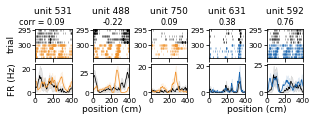

In [17]:
# plot it
f, gs = make_plots.plot_fig5cd(data, m, s, cell_IDs, \
                                FR_0, FR_1, FR_0_sem, FR_1_sem, binned_pos)
# f.savefig(save_folder + '{}_{}_cells_gain_manip.png'.format(m, s), dpi=400, bbox_inches='tight')
plt.show()

In [18]:
''' FIT K-MEANS to get map labels for each trial '''
N = 2
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        d['kmeans'] = spk.fit_kmeans(Y, n_components=N, n_restarts=100)

c:\users\ilow1\documents\python scripts\lvl\lvl\factor_models\kmeans.py:282: RuntimeWarning: invalid value encountered in subtract
  np.linalg.norm(centroids - last_centroids) /


In [20]:
# get map indices by observation and define map 0 as the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        d['idx'], d['map0_idx'] = spk.map_idx_by_obs(A, W)

In [22]:
''' identify spatially stable cells - stable in each map '''
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

stability_thresh = 0.25
all_stable = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        # load the data
        d = data[m][s]
        Y = d['Y'].copy()
        cells = d['cells']
        
        # get map indices
        W = d['kmeans']['W']
        map0 = d['map0_idx']
        map_idx = W[:, map0].astype(bool)
        
        # find cells that are stable in each map
        stable_0 = spk.find_spatially_stable(Y[map_idx])
        stable_1 = spk.find_spatially_stable(Y[~map_idx])
        
        # get index for cells that are stable in both maps                      
        stable_cells = stable_0 & stable_1
        d['stable_cells'] = stable_cells
        all_stable = np.append(all_stable, stable_cells)

all_stable = all_stable.astype(bool)        
print('n = {} stable cells (out of {} total)'.format(np.sum(all_stable), all_stable.shape[0]))

C:\Users\ilow1\Documents\Python Scripts\Low_etal_2021\analysis_pipeline\process_spikes.py:461: RuntimeWarning: invalid value encountered in greater
  stable_idx = avg_sim > stability_thresh


n = 578 stable cells (out of 1185 total)


In [29]:
# percentages across individual sessions 
total_n_cells = 0
all_pcts = np.zeros((N_sessions, 3))
i = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        n_cells = d['cells'].shape[0]
        stable_idx = d['stable_cells']
        [gc_idx, bd_idx] = d['fxn_idx']
        
        # get counts
        nongc_nonbd_stable = stable_idx & ~gc_idx & ~bd_idx
        n_gc = np.sum(gc_idx)
        n_bd = np.sum(bd_idx)
        n_sp = np.sum(nongc_nonbd_stable)
        
        # save pcts
        all_pcts[i, 0] = (n_gc/n_cells)*100
        all_pcts[i, 1] = (n_bd/n_cells)*100
        all_pcts[i, 2] = (n_sp/n_cells)*100
        
        # display results
        print(f'{m}_{s}: {n_gc/n_cells:.2%} grids, {n_bd/n_cells:.2%} borders, {n_sp/n_cells:.2%} other spatial')        
        total_n_cells += n_cells
        i += 1

Mumbai_1130_1: 13.92% grids, 6.33% borders, 27.85% other spatial
Mumbai_1201_1: 17.33% grids, 5.33% borders, 31.11% other spatial
Kerala_1207_1: 44.53% grids, 6.57% borders, 15.33% other spatial
Goa_1211_1: 10.57% grids, 10.57% borders, 24.39% other spatial
Goa_1210_1: 15.82% grids, 19.21% borders, 35.59% other spatial
Goa_1209_1: 13.25% grids, 19.28% borders, 16.87% other spatial
Punjab_1217_1: 28.57% grids, 21.43% borders, 38.10% other spatial
Punjab_1214_1: 8.54% grids, 14.63% borders, 10.98% other spatial
Salvador_1202_1: 11.76% grids, 15.69% borders, 20.92% other spatial


In [32]:
print('grid cell mean, sem: {}, {}'.format(np.round(np.mean(all_pcts[:, 0]), 2), np.round(stats.sem(all_pcts[:, 0]), 2)))
print('border cell mean, sem: {}, {}'.format(np.round(np.mean(all_pcts[:, 1]), 2), np.round(stats.sem(all_pcts[:, 1]), 2)))
print('other spatial mean, sem: {}, {}'.format(np.round(np.mean(all_pcts[:, 2]), 2), np.round(stats.sem(all_pcts[:, 2]), 2)))

grid cell mean, sem: 18.26, 3.81
border cell mean, sem: 13.23, 2.07
other spatial mean, sem: 24.57, 3.12


In [21]:
# get indices and counts
nongc_nonbd_stable = all_stable & ~all_grid & ~all_border
n_gc = np.sum(all_grid)
n_bd = np.sum(all_border)
n_sp = np.sum(nongc_nonbd_stable)

In [22]:
print('n = {} excitatory cells from {} sessions in {} mice'.format(total_n_cells, N_sessions, len(mice)))
print('n = {} grid cells'.format(n_gc))
print('n = {} border cells'.format(n_bd))
print('n = {} other spatial cells'.format(n_sp))


n = 1185 excitatory cells from 9 sessions in 5 mice
n = 224 grid cells
n = 152 border cells
n = 309 other spatial cells


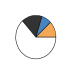

In [35]:
labels = ['grid', 'border', 'other spatial', 'other']
pcts = np.asarray([n_gc, n_bd, n_sp, total_n_cells]) / total_n_cells * 100
pie_colors = [cell_colors[0], cell_colors[1], 'k', 'w']

f, ax = plt.subplots(1, 1, figsize=(0.9, 1))
p = ax.pie(pcts, labels=None, 
              colors = pie_colors,
              wedgeprops=dict(linewidth=0.5, edgecolor='k'))
for i in range(3):
    p[0][i].set_alpha(0.8)

f.savefig(save_folder + 'pct_cell_types.png', dpi=400, bbox_inches='tight')
plt.show()

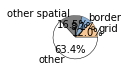

In [36]:
labels = ['grid', 'border', 'other spatial', 'other']
pcts = np.asarray([n_gc, n_bd, n_sp, total_n_cells]) / total_n_cells * 100
pie_colors = [cell_colors[0], cell_colors[1], 'k', 'w']

f, ax = plt.subplots(1, 1, figsize=(1, 1))
p = ax.pie(pcts, labels=labels, autopct='%1.1f%%', 
              colors = pie_colors,
              wedgeprops=dict(linewidth=0.5, edgecolor='k'))
for i in range(3):
    p[0][i].set_alpha(0.5)

f.savefig(save_folder + 'pct_cell_types_labels.png', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
# how do cells remap?
pct_dFR = np.asarray([])
avg_dFR = np.asarray([])
all_angles = np.asarray([])
dt = 0.02

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()
        B = d['B'].copy()
        map0_idx = d['idx'][0, :]
        map1_idx = d['idx'][1, :]
        
        # get FR by map
        FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=2, SEM=True)
        FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=2, SEM=True)
        
        # get abs % diff in peak FR
        peak_FR_1 = np.max(FR_1, axis=0)
        peak_FR_0 = np.max(FR_0, axis=0)
        dFR = (np.abs(peak_FR_1 - peak_FR_0) / ((peak_FR_1 + peak_FR_0)/2))*100
        pct_dFR = np.append(pct_dFR, dFR)
        
        # get angle between maps (spatial similarity score)
        norms_0 = np.linalg.norm(FR_0, axis=0)
        norms_1 = np.linalg.norm(FR_1, axis=0)
        angle = np.zeros(FR_0.shape[1])
        for i, n0 in enumerate(norms_0):
            n1 = norms_1[i]
            normalized_FR_0 = FR_0[:, i]/n0
            normalized_FR_1 = FR_1[:, i]/n1   
            angle[i] = normalized_FR_0 @ normalized_FR_1
        all_angles = np.append(all_angles, angle)

In [38]:
''' get colors for each cell type
orange = grid cells
blue = border cells
'''
cell_colors = np.asarray([[241, 147, 45, 255], [25, 101, 176, 255]])
cell_colors = cell_colors/255
cell_colors = list(cell_colors)
for i, c in enumerate(cell_colors):
    cell_colors[i] = tuple(c)

In [39]:
''' change in firing rate/spatial coding with remaps: border vs. grid vs. other spatial '''
# get indices
all_stable = all_stable.astype(bool)
all_grid = all_grid.astype(bool)
all_border = all_border.astype(bool)
nongc_nonbd_stable = all_stable & ~all_grid & ~all_border

# get counts
n_gc = np.sum(all_grid)
n_bd = np.sum(all_border)
n_sp = np.sum(nongc_nonbd_stable)

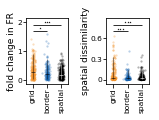

In [42]:
# get change in firing rate
dFR_gc = pct_dFR[all_grid]
dFR_bd = pct_dFR[all_border]
dFR_sp = pct_dFR[nongc_nonbd_stable]

# get change in spatial coding
angle_gc = 1 - all_angles[all_grid]
angle_bd = 1- all_angles[all_border]
angle_sp = 1- all_angles[nongc_nonbd_stable]

# plotting params
gs = gridspec.GridSpec(1, 2, wspace=0.9)
f = plt.figure(figsize=(2.2, 1.2))
PLOT_COLORS = [GC_COLOR, BD_COLOR, 'k']
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5])

# set jitter
JIT = 0.15
j_gc = np.random.randn(n_gc) * JIT
j_bd = np.random.randn(n_bd) * JIT
j_sp = np.random.randn(n_sp) * JIT

# CHANGE IN FIRING RATE
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(n_gc, POSITIONS[0])+j_gc, dFR_gc, s=PT_SIZE, lw=PT_LW, 
            color=GC_COLOR, alpha=0.3, zorder=1)
ax0.scatter(np.full(n_bd, POSITIONS[1])+j_bd, dFR_bd, s=PT_SIZE, lw=PT_LW, 
            color=BD_COLOR, alpha=0.3, zorder=1)
ax0.scatter(np.full(n_sp, POSITIONS[2])+j_sp, dFR_sp, s=PT_SIZE, lw=PT_LW, 
            color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(dFR_gc), np.median(dFR_bd), np.median(dFR_sp)])
dFR_5 = np.asarray([np.percentile(dFR_gc, 5), np.percentile(dFR_bd, 5), np.percentile(dFR_sp, 5)])
dFR_95 = np.asarray([np.percentile(dFR_gc, 95), np.percentile(dFR_bd, 95), np.percentile(dFR_sp, 95)])
ax0.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-1], dFR_medians[-1], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'w'], linestyles='solid', zorder=2, alpha=0.7)

# mark significance
xvals = np.asarray([POSITIONS[1]-0.3, POSITIONS[1], POSITIONS[1]+0.3, np.mean(POSITIONS[:-1])])
yvals = np.append(np.full(3, 198), [178])
ax0.hlines([170, 190], [POSITIONS[0], POSITIONS[0]], POSITIONS[1:], 
            colors='k', linestyles='solid', lw=LW_SIG)
ax0.scatter(xvals, yvals, c='k', marker='*', lw=0, s=SIG_SIZE)

# set axis params
ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['grid', 'border', 'spatial'], rotation=90)
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax0.set_yticks(np.arange(0, 210, 100))
ax0.set_yticklabels([0, 1, 2])
ax0.set_ylabel('fold change in FR', fontsize=9, labelpad=1)

# CHANGE IN SPATIAL CODING
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(n_gc, POSITIONS[0])+j_gc, angle_gc, s=PT_SIZE, lw=PT_LW, color=GC_COLOR, alpha=0.3, zorder=1)
ax1.scatter(np.full(n_bd, POSITIONS[1])+j_bd, angle_bd, s=PT_SIZE, lw=PT_LW, color=BD_COLOR, alpha=0.3, zorder=1)
ax1.scatter(np.full(n_sp, POSITIONS[2])+j_sp, angle_sp, s=PT_SIZE, lw=PT_LW, color='k', alpha=0.3, zorder=1)

# mark median and 95th percentiles
angle_medians = np.asarray([np.median(angle_gc), np.median(angle_bd), np.median(angle_sp)])
angle_5 = np.asarray([np.percentile(angle_gc, 5), np.percentile(angle_bd, 5), np.percentile(angle_sp, 5)])
angle_95 = np.asarray([np.percentile(angle_gc, 95), np.percentile(angle_bd, 95), np.percentile(angle_sp, 95)])
ax1.plot(POSITIONS[:-1], angle_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-1], angle_medians[-1], '_w', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, angle_5, angle_95, lw=LW_PCT, colors=['k', 'k', 'w'], linestyles='solid', zorder=2, alpha=0.7)

# mark significance
xvals = np.asarray([POSITIONS[1]-0.3, POSITIONS[1], POSITIONS[1]+0.3, 
                    np.mean(POSITIONS[:-1])-0.3, np.mean(POSITIONS[:-1]), np.mean(POSITIONS[:-1])+0.3])
yvals = np.append(np.full(3, 0.83), np.full(3, 0.73))
ax1.hlines([0.7, 0.8], [POSITIONS[0], POSITIONS[0]], POSITIONS[1:], 
            colors='k', linestyles='solid', lw=LW_SIG)
ax1.scatter(xvals, yvals, c='k', marker='*', lw=0, s=SIG_SIZE)

# set axis params
ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['grid', 'border', 'spatial'], rotation=90)
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax1.set_yticks([0, 0.3, 0.6])
ax1.set_yticklabels([0, 0.3, 0.6])
ax1.set_ylabel('spatial dissimilarity', fontsize=9, labelpad=1)

f.savefig(save_folder + 'delFR_vs_delAngle_split.png', dpi=400, bbox_inches='tight')
plt.show()

In [43]:
# significant differences?
# firing rate
FR_stat, FR_p = stats.kruskal(dFR_gc, dFR_bd, dFR_sp)
print('change in firing rate for grid vs. border vs. other spatial (Kruskal): p = {}'.format(FR_p))
GCvsBD_stat, GCvsBD_p = stats.ranksums(dFR_gc, dFR_bd)
print('grid vs. border (rank sums): p = {}'.format(GCvsBD_p))
GCvsSP_stat, GCvsSP_p = stats.ranksums(dFR_gc, dFR_sp)
print('grid vs. spatial (rank sums): p = {}'.format(GCvsSP_p))
SPvsBD_stat, SPvsBD_p = stats.ranksums(dFR_sp, dFR_bd)
print('spatial vs. border (rank sums): p = {}'.format(SPvsBD_p))

# spatial coding
angle_stat, angle_p = stats.kruskal(angle_gc, angle_bd, angle_sp)
print('\nchange in spatial coding for grid vs. border vs. other spatial (Kruskal): p = {}'.format(angle_p))
GCvsBD_stat, GCvsBD_p = stats.ranksums(angle_gc, angle_bd)
print('grid vs. border (rank sums): p = {}'.format(GCvsBD_p))
GCvsSP_stat, GCvsSP_p = stats.ranksums(angle_gc, angle_sp)
print('grid vs. spatial (rank sums): p = {}'.format(GCvsSP_p))
SPvsBD_stat, SPvsBD_p = stats.ranksums(angle_sp, angle_bd)
print('spatial vs. border (rank sums): p = {}'.format(SPvsBD_p))

change in firing rate for grid vs. border vs. other spatial (Kruskal): p = 0.00041699843547695487
grid vs. border (rank sums): p = 0.04607772209515754
grid vs. spatial (rank sums): p = 7.49315521923342e-05
spatial vs. border (rank sums): p = 0.1870905076374364

change in spatial coding for grid vs. border vs. other spatial (Kruskal): p = 1.9729385771983884e-05
grid vs. border (rank sums): p = 4.138898520521993e-05
grid vs. spatial (rank sums): p = 0.00012925900408592103
spatial vs. border (rank sums): p = 0.21345300740099238


In [44]:
print('n grid cells total = ' + str(n_gc))
print('median change in firing rate = {}'.format(np.round(np.median(dFR_gc), 3)))
print('95th percentile change in firing rate = {}'.format(np.round(np.percentile(dFR_gc, 95), 3)))
print('median change in spatial tuning = {}'.format(np.round(np.median(angle_gc), 3)))
print('95th percentile change in spatial tuning = {}'.format(np.round(np.percentile(angle_gc, 95), 3)))

print('\nn border cells total = ' + str(n_bd))
print('median change in firing rate = {}'.format(np.round(np.median(dFR_bd), 3)))
print('95th percentile change in firing rate = {}'.format(np.round(np.percentile(dFR_bd, 95), 3)))
print('median change in spatial tuning = {}'.format(np.round(np.median(angle_bd), 3)))
print('95th percentile change in spatial tuning = {}'.format(np.round(np.percentile(angle_bd, 95), 3)))

print('\nn spatial cells total = ' + str(n_sp))
print('median change in firing rate = {}'.format(np.round(np.median(dFR_sp), 3)))
print('95th percentile change in firing rate = {}'.format(np.round(np.percentile(dFR_sp, 95), 3)))
print('median change in spatial tuning = {}'.format(np.round(np.median(angle_sp), 3)))
print('95th percentile change in spatial tuning = {}'.format(np.round(np.percentile(angle_sp, 95), 3)))

n grid cells total = 224
median change in firing rate = 25.582
95th percentile change in firing rate = 89.151
median change in spatial tuning = 0.027
95th percentile change in spatial tuning = 0.334

n border cells total = 152
median change in firing rate = 20.629
95th percentile change in firing rate = 71.675
median change in spatial tuning = 0.019
95th percentile change in spatial tuning = 0.137

n spatial cells total = 309
median change in firing rate = 18.227
95th percentile change in firing rate = 55.467
median change in spatial tuning = 0.022
95th percentile change in spatial tuning = 0.119


In [46]:
''' plot example grids/borders '''
m = 'Kerala'
s = '1207_1'
cell_IDs = [531, 488, 750, 631, 592]

d = data[m][s]
A = d['A']
B = d['B'].copy()
Y = d['Y'].copy()
cells = d['cells'].copy()
[grid_idx, border_idx] = d['fxn_idx']

In [47]:
# percent/n grid and border cells
total_n_cells = d['cells_int'].shape[0]
n_excite_cells = cells.shape[0]
n_gc = np.sum(grid_idx)
n_bd = np.sum(border_idx)

print('N cells total = {}'.format(total_n_cells))
print('N excitatory cells total = {}'.format(n_excite_cells))
print('\nN putative grid cells = {}'.format(n_gc))
print('% putative grid cells = {}%'.format(np.round((n_gc/total_n_cells)*100, 1)))
print('\nN putative border cells = {}'.format(n_bd))
print('% putative border cells = {}%'.format(np.round((n_bd/total_n_cells)*100, 1)))

N cells total = 165
N excitatory cells total = 137

N putative grid cells = 61
% putative grid cells = 37.0%

N putative border cells = 9
% putative border cells = 5.5%


In [48]:
cells[border_idx.astype(bool)]

array([133, 247, 784, 802, 592, 600, 606, 619, 631], dtype=uint16)

In [49]:
# get map indices
W = d['kmeans']['W']
map0_idx = d['idx'][0, :]
map1_idx = d['idx'][1, :]

# get FR by position in each map for all cells   
FR, binned_pos, FR_sem = spk.tuning_curve(A[:, 0], B, dt, b=2, SEM=True)
FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=2, SEM=True)
FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=2, SEM=True)

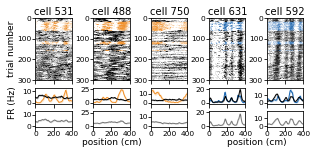

In [54]:
''' example cell rasters and TCs - map 0 vs. 1 '''
gs = gridspec.GridSpec(5, 5, hspace=0.5, wspace=0.6)
f = plt.figure(figsize=(4.8, 2)) 
PT_SIZE = 1
LW_MEAN = 1
LW_SEM = 0.3

for i, cell_ID in enumerate(cell_IDs):
    # set axes
    ax0 = plt.subplot(gs[:3, i])
    ax1 = plt.subplot(gs[3:4, i])
    ax2 = plt.subplot(gs[4:, i])
    
    # set color
    if i >= 3:
        cell_color = cell_colors[1]
    else:
        cell_color = cell_colors[0]
    
    # draw raster
    sdx = B[map0_idx, np.where(cells==cell_ID)[0][0]].astype(bool)
    ax0.scatter(A[map0_idx, 0][sdx], A[map0_idx, 2][sdx], 
                color=cell_color, lw=0, s=PT_SIZE, alpha=.1)
    sdx = B[map1_idx, np.where(cells==cell_ID)[0][0]].astype(bool)
    ax0.scatter(A[map1_idx, 0][sdx], A[map1_idx, 2][sdx], 
                color='k', lw=0, s=PT_SIZE, alpha=.1)
    
    # plot tuning curves with SEM
    sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
    ax1.plot(FR_0[:, sdx], color=cell_color, lw=LW_MEAN, alpha=1)
    ax1.fill_between(binned_pos/2, FR_0[:, sdx] + FR_0_sem[:, sdx], 
                     FR_0[:, sdx] - FR_0_sem[:, sdx],
                     color=cell_color, linewidth=LW_SEM, alpha=0.2)
    ax1.plot(FR_1[:, sdx], color='k', lw=LW_MEAN, alpha=1)
    ax1.fill_between(binned_pos/2, FR_1[:, sdx] + FR_1_sem[:, sdx], 
                     FR_1[:, sdx] - FR_1_sem[:, sdx],
                     color='k', linewidth=LW_SEM, alpha=0.2)    
    
    # plot naive tuning curve with SEM
    sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
    ax2.plot(FR[:, sdx], 'k', lw=LW_MEAN, alpha=0.5)
    ax2.fill_between(binned_pos/2, FR[:, sdx] + FR_sem[:, sdx], FR[:, sdx] - FR_sem[:, sdx],
                     color='k', linewidth=LW_SEM, alpha=0.1)

    # format axes
    ax0.set_xlim((0, 400))
    ax0.set_xticks(np.arange(0, 425, 200))
    ax0.tick_params(labelbottom=False)
    ylim_ax = [0, np.max(A[:, 2])]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_yticks(np.arange(0, 350, 100))
    ax0.set_title("cell {}".format(cell_ID), fontsize=10, pad=3)
     
    if i == 0:
        ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
        ax2.set_ylabel('FR (Hz)', horizontalalignment='left', fontsize=9, labelpad=5)
        
    ax1.set_xlim([0, 200])
    ax1_lims = ax1.get_ylim()
    ax1.set_xticks(np.arange(0, 225, 100))
    ax1.tick_params(labelbottom=False)
    ax2.set_xlim([0, 200])
    ax2.set_ylim(ax1_lims)
    ax2.set_xticks(np.arange(0, 225, 100))
    ax2.set_xticklabels(np.arange(0, 450, 200))
    ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax2.tick_params(which='major', labelsize=7.5, pad=0.5)

    if i == 1:
        ax2.set_xlabel('position (cm)', fontsize=9, labelpad=1)
    elif i == 3:
        ax2.set_xlabel('position (cm)', fontsize=9, labelpad=1, horizontalalignment='left', x=0.5)        
    
f.savefig(save_folder + m + '_' + s + '_example_rasters.png', dpi=400, bbox_inches='tight')
plt.show()